In [1]:
from sklearn.model_selection import train_test_split

from scripts.data_genertion.consts import *
from scripts.data_genertion.data_handling import populate_features, get_populate_fold
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

Loading features from: ['ASO_volume(nM).csv', 'Canonical Gene Name.csv', 'Cell line organism.csv', 'Cell_line.csv', 'Chemical_Pattern.csv', 'Density(cells_per_well).csv', 'ISIS.csv', 'Inhibition(%).csv', 'Linkage.csv', 'Linkage_Location.csv', 'Location.csv', 'Location_div_by_length.csv', 'Location_in_sequence.csv', 'Modification.csv', 'Primer_probe_set.csv', 'Sequence.csv', 'Target_gene.csv', 'Transcript.csv', 'Transfection.csv', 'Treatment_Period(hours).csv', 'at_rich_region_score.csv', 'at_skew.csv', 'cell_line_uniform.csv', 'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_woGU_pos1382t3

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']

In [5]:
from scripts.data_genertion.consts import *


class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in ['md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                           'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600'
                           ]:
                self.hybridization.append(feature)
            if CELL_LINE in feature:
                self.one_hot.append(feature)
            if feature in ['at_skew', 'gc_content', 'entropy', 'gc_skew',
                           'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold',
                           'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score',
                           'poly_pyrimidine_stretch', 'normalized_start']:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold


main_df.columns

Index(['index', 'ASO_volume(nM)', 'Canonical Gene Name', 'Cell line organism',
       'Cell_line', 'Chemical_Pattern', 'Density(cells_per_well)', 'ISIS',
       'Inhibition(%)', 'Linkage', 'Linkage_Location', 'Location',
       'Location_div_by_length', 'Location_in_sequence', 'Modification',
       'Primer_probe_set', 'Sequence', 'Target_gene', 'Transcript',
       'Transfection', 'Treatment_Period(hours)', 'at_rich_region_score',
       'at_skew', 'cell_line_uniform',
       'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Trueon_target_energy_max600',

In [6]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [7]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'sense_start_from_end')

In [96]:
import numpy as np

filtered = main_df.copy()
filtered = filtered[filtered['Cell line organism'] == 'human']
filtered = filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.01
filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - filtered[INHIBITION] / 100)
filtered = filtered[~filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]

In [232]:
import numpy as np

# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']
def log_inhibition_to_regular(log_inhibition):
    return 100 * (-np.exp(-log_inhibition) + log_correction)


mean_metric = 'log_inhibition'

filtered['mean_inhibition'] = filtered.groupby('ISIS')[mean_metric].transform('mean')
filtered = filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: filtered['mean_inhibition']}).drop(
    columns='mean_inhibition')

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
# filtered['correct_log_inhibition'] = li


features_obj = Features(filtered.columns)
features_obj.hybridization = ['exp_ps_hybr']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
    TREATMENT_PERIOD,
    # 'log_volume',
    # DENSITY_UPDATED
]

# features = epi_features
features = epi_features + features

In [233]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRanker

seed = 43

train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
train = train.sort_values(CELL_LINE)
group_train = train.groupby(CELL_LINE).size().tolist()
metric = 'correct_log_inhibition'

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
# y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
y = train[metric]

model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed)
# model = XGBRanker(objective='rank:pairwise')
model.fit(X.to_numpy(), y.to_numpy(), group=group_train)


Test:  3387
Train:  13544


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, feature_weights=None,
          gamma=None, grow_policy=None, importance_type=None,
          interaction_constraints=None, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

correct_log_inhibition
Cell line:  A431
P:  0.422758702570334
S:  0.3375069109162876
correct_log_inhibition
Cell line:  Human IPS
P:  0.8049740817475108
S:  0.7852734653720582
correct_log_inhibition
Cell line:  KARPAS-229
P:  0.5586293846200109
S:  0.5616008030902195
correct_log_inhibition
Cell line:  A-431
P:  0.8787289130481744
S:  0.7206268740527327
correct_log_inhibition
Cell line:  MM.1R
P:  0.5984870390755417
S:  0.5938066458290462
correct_log_inhibition
Cell line:  SK-MEL-28
P:  0.46431322738016545
S:  0.4420630309465208
correct_log_inhibition
Cell line:  SNU-449
P:  0.5503975323653161
S:  0.4537858196691231
correct_log_inhibition
Cell line:  HepaRG
P:  0.41508775865128644
S:  0.3011965269186128
correct_log_inhibition
Cell line:  U251
P:  0.7211237490592257
S:  0.6394875025255358
correct_log_inhibition
Cell line:  HepG2
P:  0.5648378298240848
S:  0.5223966362565108
correct_log_inhibition
Feature:  Treatment_Period(hours)
P:  0.10100084878550511
S:  -0.03596991608639316


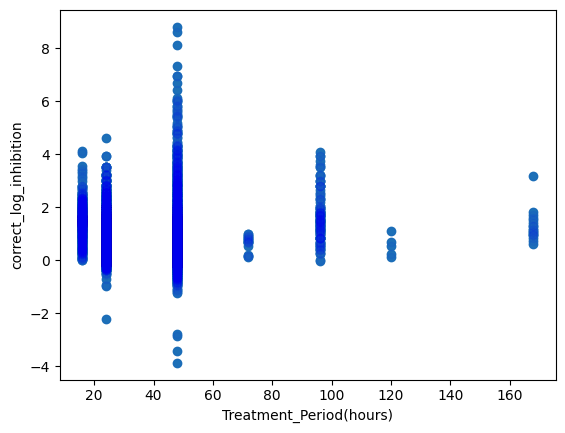

correct_log_inhibition
Feature:  exp_ps_hybr
P:  -0.032507339045179634
S:  -0.020620290354320937


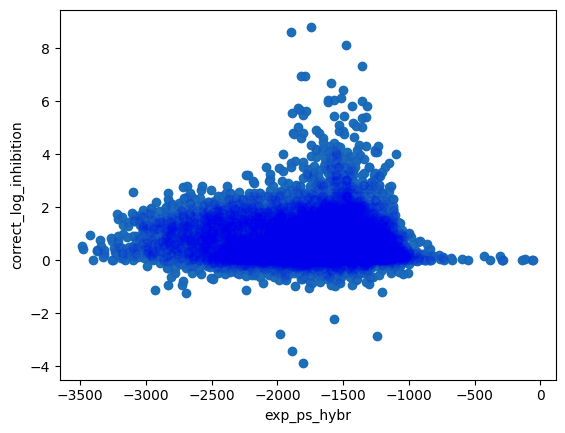

correct_log_inhibition
Feature:  at_rich_region_score
P:  0.021096510394231473
S:  0.006998560648600965


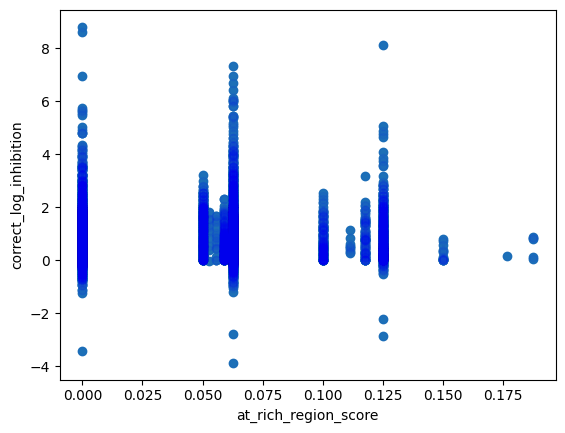

correct_log_inhibition
Feature:  at_skew
P:  -0.1738738587921151
S:  -0.16345662018761345


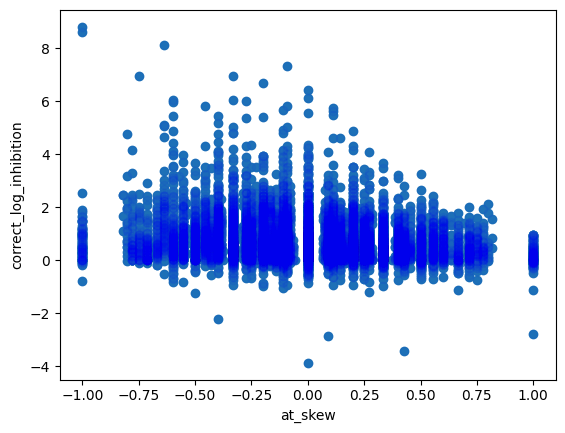

correct_log_inhibition
Feature:  entropy
P:  0.05512951424286803
S:  0.08671990409975391


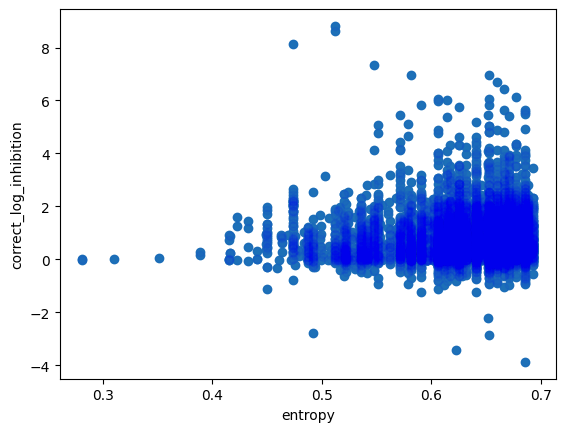

correct_log_inhibition
Feature:  gc_content
P:  -0.08859881616908809
S:  -0.06962077445632618


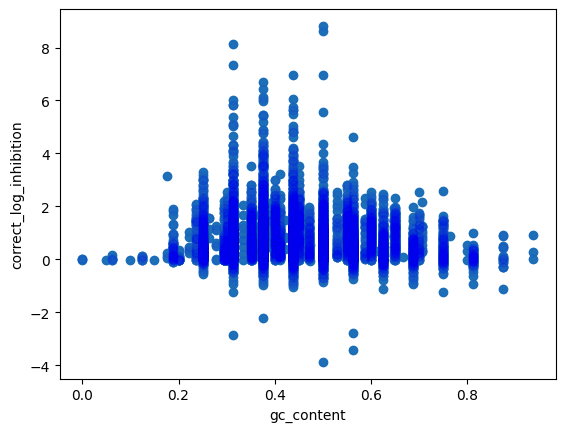

correct_log_inhibition
Feature:  gc_content_3_prime_5
P:  -0.03179880597023478
S:  -0.030056670142831938


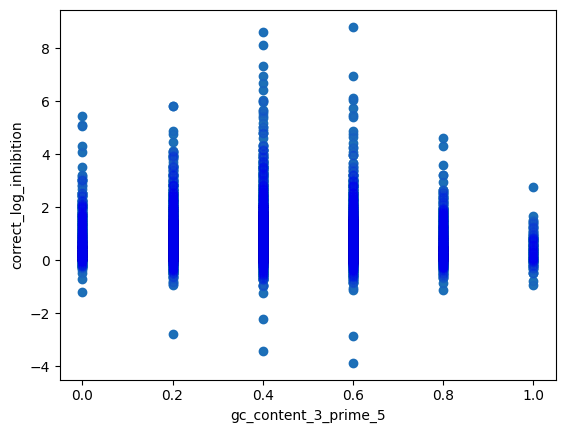

correct_log_inhibition
Feature:  gc_skew
P:  0.049066341463125496
S:  0.050276119859067936


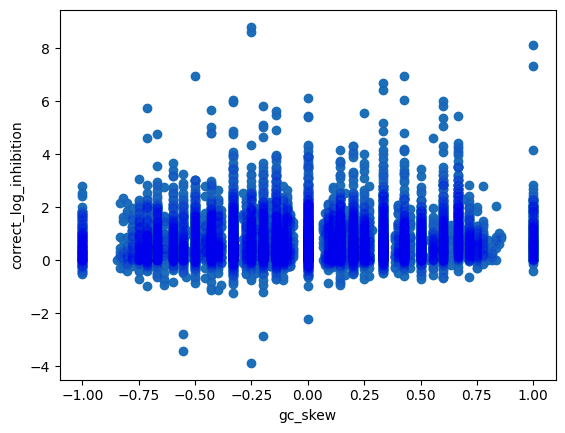

correct_log_inhibition
Feature:  hairpin_score
P:  -0.017290747830187754
S:  -0.015336418101544711


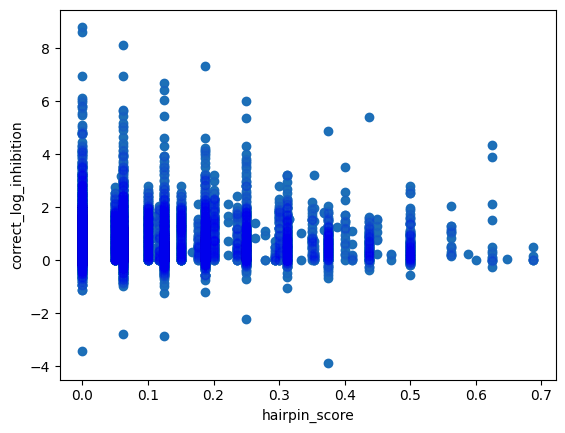

correct_log_inhibition
Feature:  homooligo_count
P:  -0.035508384843419075
S:  -0.039818661739430515


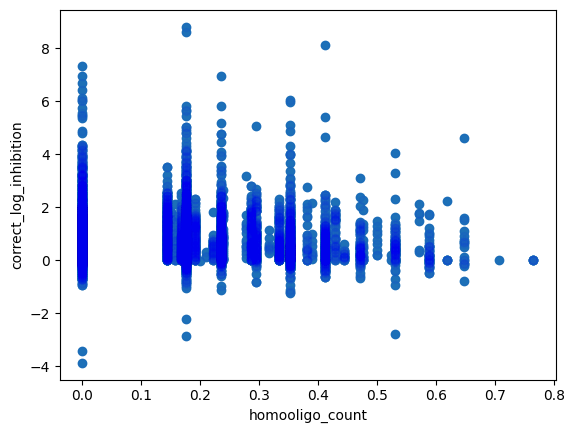

correct_log_inhibition
Feature:  internal_fold
P:  0.055234311304015446
S:  0.06589880475220732


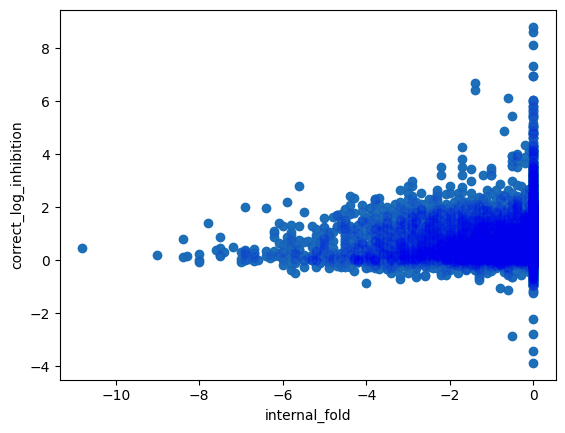

correct_log_inhibition
Feature:  normalized_start
P:  0.08657627056605058
S:  0.12076308041788766


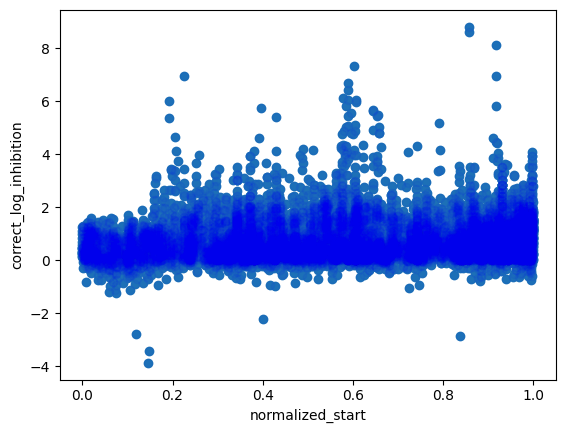

correct_log_inhibition
Feature:  nucleotide_diversity
P:  0.10638598643915602
S:  0.12127220476687435


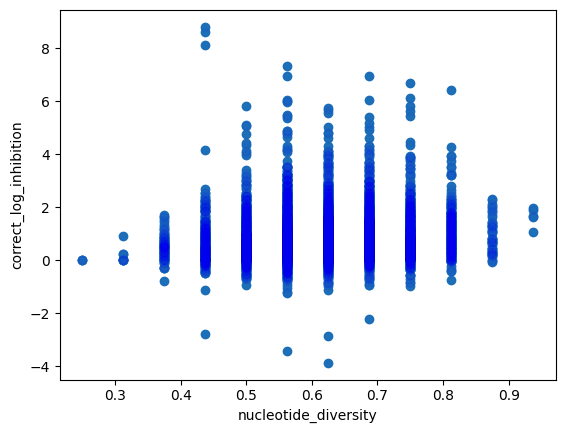

correct_log_inhibition
Feature:  poly_pyrimidine_stretch
P:  0.06787911642861882
S:  0.03666139612353247


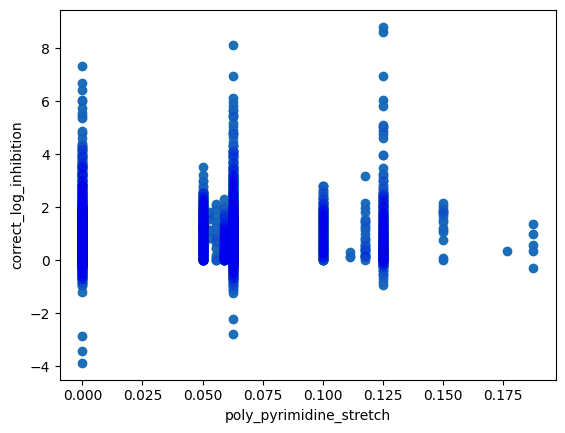

correct_log_inhibition
Feature:  self_energy
P:  0.04208211771217493
S:  0.029152825247179756


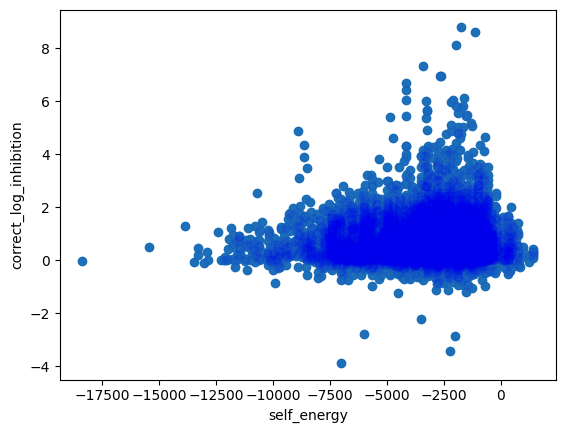

correct_log_inhibition
Feature:  stop_codon_count
P:  -0.041244476561868394
S:  -0.04047155957390482


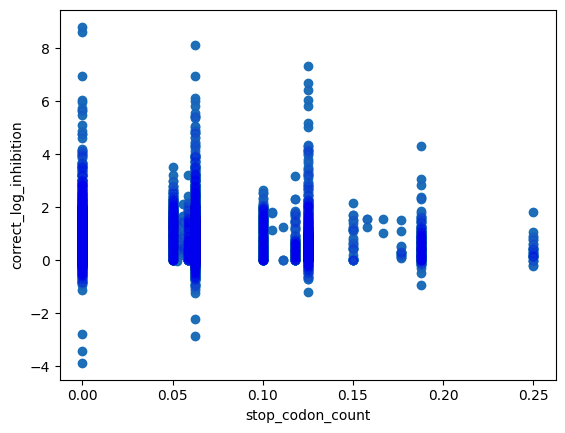

correct_log_inhibition
Feature:  on_target_fold_openness_normalized40_15
P:  0.21084239397152588
S:  0.21923423283218071


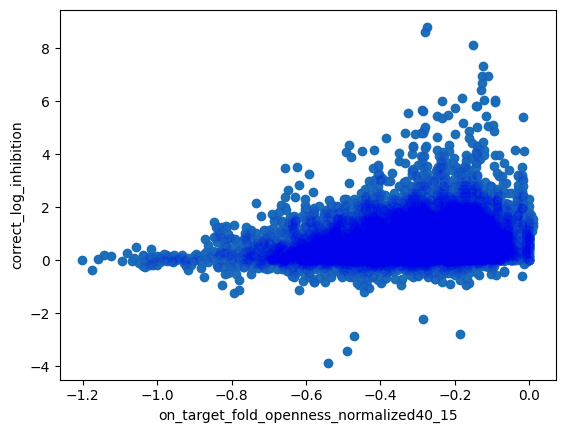

P:  0.4367117212742591
S:  0.3940307803861998
PTRAIN:  0.4469456264302678
PTEST:  0.39497252945826283
STRAIN:  0.39861312947632604
STEST:  0.37609830416994106


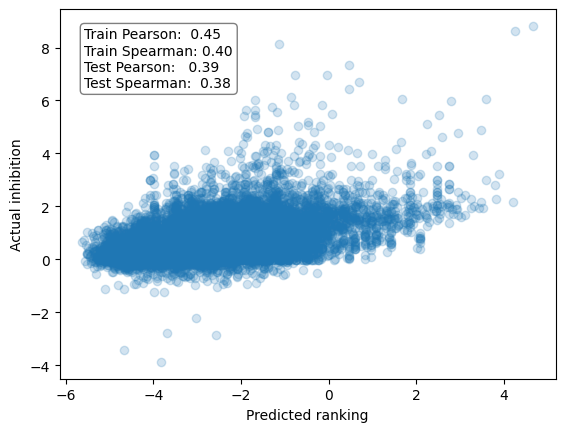

In [234]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
# for cell_line in cell_lines:
for cell_line in cell_lines:
    hepa_mask = filtered[CELL_LINE] == cell_line
    hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
    print(metric)
    hepa_truth = filtered[hepa_mask][metric]
    p_hepa, _ = pearsonr(hepa_truth, hep_pred)
    s_hepa, _ = spearmanr(hepa_truth, hep_pred)
    print("Cell line: ", cell_line)
    print("P: ", p_hepa)
    print("S: ", s_hepa)

for feature in features:
    # EXAMPLE = 'GGCATATGCAGATAATGTTC'

    # malat_mask = filtered[CANONICAL_GENE] == "IRF4"
    malat_mask = filtered[CANONICAL_GENE] != "MALAT2"
    # example_mask = (filtered[CANONICAL_GENE] == "MALAT1") & (filtered[SEQUENCE] == EXAMPLE)
    malat_pred = model.predict(filtered[malat_mask][features].to_numpy())
    print(metric)
    malat_truth = filtered[malat_mask][metric]
    p_hepa, _ = pearsonr(malat_truth, filtered[malat_mask][feature])
    s_hepa, _ = spearmanr(malat_truth, filtered[malat_mask][feature])

    plt.scatter(filtered[malat_mask][feature], malat_truth)
    # example_df = filtered.loc[example_mask, :].copy()
    # plt.scatter(example_df[feature], malat_truth[example_mask], color='orange')
    plt.scatter(filtered[malat_mask][feature], malat_truth, color='blue', alpha=0.05)
    plt.xlabel(feature)
    plt.ylabel(metric)
    print("Feature: ", feature)
    print("P: ", p_hepa)
    print("S: ", s_hepa)
    plt.show()

p_hepa, _ = pearsonr(malat_truth, malat_pred)
s_hepa, _ = spearmanr(malat_truth, malat_pred)
print("P: ", p_hepa)
print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, _ = pearsonr(y_test, test_pred)
s_test, _ = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)

# scatter plot
# plt.scatter(test_pred, y_test, alpha=0.2)
plt.scatter(malat_pred, malat_truth, alpha=0.2)

# least‑squares regression line
# slope, intercept = np.polyfit(test_pred, y_test, 1)
# x = np.linspace(test_pred.min(), test_pred.max(), 100)
# plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel('Actual inhibition')
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [235]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [236]:
def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


# def correction(df):
#     return (df['log_volume'])

def correction(df):
    return (df[VOLUME] + 10) / df[VOLUME]


for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']))
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

Threshold for top_1: 92.0
Threshold for top_5: 83.0
Threshold for top_10: 76.0
Threshold for top_50: 39.0


Mean model:  86.74360292595448
Mean best:  100.99642877427968
Mean random:  50.274985847394305


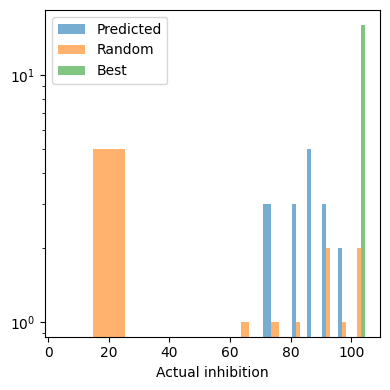

In [237]:
percentile = 0.5

train_threshold = get_threshold_for_percentile(percentile, train_pred)
test_threshold = get_threshold_for_percentile(percentile, test_pred)

test_mask = test_pred > test_threshold

top_k = test_mask.sum()

train_mask = train_pred > train_threshold

top_predicted_train = train_pred[train_mask]

top_train = log_inhibition_to_regular(y_train[train_mask] * correction(train_filtered[train_mask]))

top_predicted_test = test_pred[test_mask]
top_test = log_inhibition_to_regular(y_test[test_mask] * correction(test_filtered[test_mask]))

# k already computed as the desired sample size
rand_mask = np.zeros(len(y_test), dtype=bool)
rand_mask[np.random.choice(len(y_test), top_k, replace=False)] = True

# ---------- best possible ----------
all_inhib = log_inhibition_to_regular(y_test * correction(test_filtered))
top_best = all_inhib.nlargest(top_k).to_numpy()  # no index confusion

# random sample via mask
rand_perm = y_test[rand_mask]
top_rand_test = log_inhibition_to_regular(y_test[rand_mask] * correction(test_filtered[rand_mask]))

fig, ax = plt.subplots(figsize=(4, 4))
# ax.boxplot([top_test, top_rand_test],
#            tick_labels=['Top‑predicted', 'Random baseline']
#            )
print("Mean model: ", np.mean(top_test))
print("Mean best: ", np.mean(top_best))
print("Mean random: ", np.mean(top_rand_test))

# print("Mean model: ", geo_mean_overflow(top_test))
# print("Mean best: ", geo_mean_overflow(top_best))
# print("Mean random: ", geo_mean_overflow(top_rand_test))
plt.hist([top_test, top_rand_test, top_best],
         bins=[0, 40, 60, 70, 80, 85, 90, 95, 100, 105], alpha=0.6,
         label=['Predicted', 'Random', 'Best'], log=True)  # ‑‑ y‑axis on log scale
plt.xlabel('Actual inhibition')
plt.legend()
plt.tight_layout()
plt.show()


In [238]:
MALAT_scores = model.predict(filtered[filtered[CANONICAL_GENE] == 'MALAT1'][features])
MALAT_scores.sort()
print(MALAT_scores)
get_threshold_for_percentile(1, MALAT_scores)

[-5.3541436 -5.307081  -5.295958  ...  3.5826783  4.255633   4.660191 ]


np.float32(0.6766615)

In [239]:
# ---------------------------------------------------------------------------
# 5-fold “stable” permutation-importance for an XGBRanker (rank:pairwise)
# – one query = all rows that share the same CELL_LINE ----------------------
# ---------------------------------------------------------------------------

from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from scipy import stats
import numpy as np
import pandas as pd

metric = "correct_log_inhibition"  # target column
groups = filtered[CELL_LINE]  # one “qid” per row
gkf = GroupKFold(n_splits=6)


def spearman_scorer(est, X, y):  # (estimator, X, y) signature
    return stats.spearmanr(y, est.predict(X)).correlation ** 2


all_imps = []

for tr_idx, te_idx in gkf.split(filtered, filtered[metric], groups):
    # ---- build train / test sets -----------------------------------------
    train_df = filtered.iloc[tr_idx].sort_values(CELL_LINE)  # keep queries contiguous
    test_df = filtered.iloc[te_idx]

    X_tr, y_tr = train_df[features], train_df[metric]
    X_te, y_te = test_df[features], test_df[metric]

    group_train = train_df.groupby(CELL_LINE).size().tolist()  # sizes per query

    # ---- fit a fresh ranker on this fold ---------------------------------
    ranker = XGBRanker(objective="rank:pairwise", random_state=42)
    ranker.fit(X_tr.to_numpy(), y_tr.to_numpy(), group=group_train)

    # ---- permutation importance on the hold-out --------------------------
    r = permutation_importance(
        ranker, X_te.to_numpy(), y_te.to_numpy(),
        n_repeats=30, scoring=spearman_scorer,
        random_state=42, n_jobs=-1
    )
    all_imps.append(r.importances_mean)

# --------------------------------------------------------------------------
# aggregate across folds
imp_mat = np.vstack(all_imps)  # (folds × features)
imp_df = pd.DataFrame(
    imp_mat.T,
    index=features,
    columns=[f"fold_{i + 1}" for i in range(imp_mat.shape[0])]
)

summary = (imp_df
           .agg(["mean", "std"], axis=1)
           .rename(columns={"mean": "mean_imp", "std": "std_imp"})
           .sort_values("mean_imp", ascending=False))

print(summary.head(10))

KeyboardInterrupt: 

In [240]:

GFP_IN_YEAST = (
    'ATGGTtAGtAAaGGaGAaGAGTTgTTCACaGGaGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGGTGCTGGGGCAggtacCCCTAAAGATCCAGCCAAACCTCCGGCCAcGGCACAAGTTGTGGGATGGCCACCGGTGAGATCATACCGGAAGAACGTGATGGTTTCCTGCCAAAAATCAAGCGGTGGCCCGGAGGCGGCGGCGTTCGTGAAGTAA'
    .upper())
GFP_IN_HUMAN = (
    "atggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagaagcttagccatggcttcccgccggaggtggaggagcaggatgatggcacgctgcccatgtcttgtgcccaggagagcgggatggaccgtcaccctgcagcctgtgcttctgctaggatcaatgtgaagcgacctgccgccacaaagaaggctggacaggctaagaagaagaaatgaggatcccgcgcgcgcatatgttaattaaccaactgcatggggatccacgcgttaagtcgacaatcaacctctggattacaaaatttgtgaaagattgactggtattcttaactatgttgctccttttacgctatgtggatacgctgctttaatgcctttgtatcatgctattgcttcccgtatggctttcattttctcctccttgtataaatcctggttgctgtctctttatgaggagttgtggcccgttgtcaggcaacgtggcgtggtgtgcactgtgtttgctgacgcaacccccactggttggggcattgccaccacctgtcagctcctttccgggactttcgctttccccctccctattgccacggcggaactcatcgccgcctgccttgcccgctgctggacaggggctcggctgttgggcactgacaattccgtggtgttgtcggggaaatcatcgtcctttccttggctgctcgcctgtgttgccacctggattctgcgcgggacgtccttctgctacgtcccttcggccctcaatccagcggaccttccttcccgcggcctgctgccggctctgcggcctcttccgcgtcttcgccttcgccctcagacgagtcggatctccctttgggccgcctccccgcgtcgactttaagaccaatgacttacaaggcagctgtagatcttagccactttttaaaagaaaaggggggactggaagggctaattcactcccaacgaagacaagatctgctttttgcttgtactgggtctctctggttagaccagatctgagcctgggagctctctggctaactagggaacccactgcttaagcctcaataaagcttgccttgagtgcttcaagtagtgtgtgcccgtctgttgtgtgactctggtaactagagatccctcagacccttttagtcagtgtggaaaatctctagcagtacgtatagtagttcatgtcatcttattattcagtatttataacttgcaaagaaatgaatatcagagagtgagagg".upper()
)
# GFP + Degron x <= 842
# NLS 843 <= x<= 893
# 3UTR 1615 <= x <= 1848


In [241]:
from scripts.data_genertion.data_handling import get_unique_human_genes

from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=['MALAT1'])
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

MALAT = gene_to_data['MALAT1'].full_mrna

In [242]:
from asodesigner.util import get_antisense
import pandas as pd

GFP_YEAST_END = len(GFP_IN_YEAST) - 3
GFP_HUMAN_END = 891  # TGA stop codon in NLS
malat_info = gene_to_data['MALAT1']
MALAT_END = malat_info.exon_indices[-1][1] - malat_info.cds_start


def get_init_df(target_mrna, end):
    candidates = []
    sense_starts = []
    sense_lengths = []
    sense_starts_from_end = []

    for i in range(0, len(target_mrna) - 19):
        target = target_mrna[i: i + 20]
        candidates.append(get_antisense(str(target)))
        sense_starts.append(i)
        sense_lengths.append(20)
        sense_starts_from_end.append(end - i)
    df = pd.DataFrame(
        {SEQUENCE: candidates, SENSE_START: sense_starts,
         SENSE_LENGTH: sense_lengths, "sense_start_from_end": sense_starts_from_end})
    return df

SEQUENCES = [GFP_IN_YEAST, GFP_IN_HUMAN, MALAT]
df_yeast = get_init_df(GFP_IN_YEAST, GFP_YEAST_END)
df_human = get_init_df(GFP_IN_HUMAN, GFP_HUMAN_END)
df_malat = get_init_df(MALAT, MALAT_END)

In [243]:
features

['Treatment_Period(hours)',
 'exp_ps_hybr',
 'at_rich_region_score',
 'at_skew',
 'entropy',
 'gc_content',
 'gc_content_3_prime_5',
 'gc_skew',
 'hairpin_score',
 'homooligo_count',
 'internal_fold',
 'normalized_start',
 'nucleotide_diversity',
 'poly_pyrimidine_stretch',
 'self_energy',
 'stop_codon_count',
 'on_target_fold_openness_normalized40_15']

In [244]:
from scripts.data_genertion.data_handling import populate_features

df_yeast[CANONICAL_GENE] = 'YEAST_GFP'
df_human[CANONICAL_GENE] = 'HUMAN_GFP'
df_malat[CANONICAL_GENE] = 'MALAT'

dataframes = [df_yeast, df_human, df_malat]

for i, df in enumerate(dataframes):
    df[TREATMENT_PERIOD] = 24  # keep constant for all
    df[VOLUME] = 1000  # keep constant for all
    df['log_volume'] = np.log(df[VOLUME])
    df['normalized_start'] = df[SENSE_START] / len(SEQUENCES[i])
    df['normalized_sense_start_from_end'] = df['sense_start_from_end'] / len(SEQUENCES[i])
    easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                        'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                        'at_rich_region_score', 'poly_pyrimidine_stretch']
    populate_features(df, easy_to_populate)


In [245]:
%reload_ext autoreload
%autoreload 2

from asodesigner.process_utils import LocusInfo
from scripts.data_genertion.data_handling import get_populate_fold

genes_u = ['YEAST_GFP', 'HUMAN_GFP', 'MALAT']
gene_to_data = {'YEAST_GFP': LocusInfo(), 'HUMAN_GFP': LocusInfo(), 'MALAT': LocusInfo()}
gene_to_data['YEAST_GFP'].full_mrna = GFP_IN_YEAST
gene_to_data['HUMAN_GFP'].full_mrna = GFP_IN_HUMAN
gene_to_data['MALAT'].full_mrna = MALAT


In [246]:
for i in range(len(dataframes)):
    fold_variants = [(40, 15)]
    dataframes[i] = get_populate_fold(dataframes[i], genes_u, gene_to_data, fold_variants=fold_variants)


[-1.10000000e+001 -3.50000000e+000 -3.79999995e+000 -6.30000019e+000
 -1.20000000e+001 -1.40000000e+001 -8.50000000e+000 -5.50000000e+000
 -8.30000019e+000 -8.10000038e+000 -1.36999998e+001 -1.28999996e+001
 -8.50000000e+000 -1.11999998e+001 -1.35000000e+001 -1.06000004e+001
 -4.80000019e+000 -8.60000038e+000 -1.03000002e+001 -7.19999981e+000
 -8.80000019e+000 -4.09999990e+000 -1.61000004e+001 -3.00000000e+000
 -6.80000019e+000 -4.80000019e+000 -1.20000005e+000 -1.89999998e+000
  0.00000000e+000 -1.41999998e+001 -8.50000000e+000 -8.50000000e+000
 -1.11999998e+001 -1.25000000e+001 -5.00000000e+000 -8.19999981e+000
 -6.59999990e+000 -9.89999962e+000 -1.01999998e+001 -1.08000002e+001
 -7.30000019e+000 -9.80000019e+000 -1.58999996e+001 -1.06999998e+001
 -1.33000002e+001 -1.38999996e+001 -1.28999996e+001 -1.56000004e+001
 -1.25000000e+001 -5.30000019e+000 -4.19999981e+000 -2.79999995e+000
 -9.60000038e+000 -5.40000010e+000 -2.00000000e+000 -7.00000000e+000
 -1.46999998e+001 -9.60000038e+000

In [247]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

for df in dataframes:
    df.loc[:, 'exp_ps_hybr'] = [
        get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
        antisense in df[SEQUENCE]]

In [248]:
scores_per_gfp = []
for df in dataframes:
    scores_per_gfp.append(model.predict(df[features]))

In [249]:
index = 0
scores = scores_per_gfp[index]
k = 30  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('yeast_gfp_asos.csv', index=False)

                 Sequence  sense_start  sense_length  sense_start_from_end  \
492  TTGTGGCGGATCTTGAAGTT          492            20                   375   
493  GTTGTGGCGGATCTTGAAGT          493            20                   374   
491  TGTGGCGGATCTTGAAGTTC          491            20                   376   
490  GTGGCGGATCTTGAAGTTCA          490            20                   377   
476  AGTTCACCTTGATGCCGTTC          476            20                   391   
496  GATGTTGTGGCGGATCTTGA          496            20                   371   
498  TCGATGTTGTGGCGGATCTT          498            20                   369   
494  TGTTGTGGCGGATCTTGAAG          494            20                   373   
473  TCACCTTGATGCCGTTCTTC          473            20                   394   
472  CACCTTGATGCCGTTCTTCT          472            20                   395   
489  TGGCGGATCTTGAAGTTCAC          489            20                   378   
474  TTCACCTTGATGCCGTTCTT          474            20            

In [250]:
index = 1
scores = scores_per_gfp[index]
k = 30  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('human_gfp_asos.csv', index=False)


                  Sequence  sense_start  sense_length  sense_start_from_end  \
868   CTTCTTCTTAGCCTGTCCAG          868            20                    23   
870   TTCTTCTTCTTAGCCTGTCC          870            20                    21   
869   TCTTCTTCTTAGCCTGTCCA          869            20                    22   
476   AGTTCACCTTGATGCCGTTC          476            20                   415   
492   TTGTGGCGGATCTTGAAGTT          492            20                   399   
465   ATGCCGTTCTTCTGCTTGTC          465            20                   426   
1556  CTGCCTTGTAAGTCATTGGT         1556            20                  -665   
1555  TGCCTTGTAAGTCATTGGTC         1555            20                  -664   
867   TTCTTCTTAGCCTGTCCAGC          867            20                    24   
879   GATCCTCATTTCTTCTTCTT          879            20                    12   
950   ATCCAGAGGTTGATTGTCGA          950            20                   -59   
472   CACCTTGATGCCGTTCTTCT          472            2

In [251]:
index = 2
scores = scores_per_gfp[index]
k = 30  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('malat_asos.csv', index=False)

                  Sequence  sense_start  sense_length  sense_start_from_end  \
5245  GGACATTGCCTCTTCATTGT         5245            20                  3584   
7558  CGCTTTGTTGTCTCTCCTGC         7558            20                  1271   
5377  GCCTCCTCAATCCACTTGAT         5377            20                  3452   
4994  CTCTGCATCTAGGCCATCAT         4994            20                  3835   
5375  CTCCTCAATCCACTTGATCC         5375            20                  3454   
5378  AGCCTCCTCAATCCACTTGA         5378            20                  3451   
4995  TCTCTGCATCTAGGCCATCA         4995            20                  3834   
5251  TGAGATGGACATTGCCTCTT         5251            20                  3578   
5380  ACAGCCTCCTCAATCCACTT         5380            20                  3449   
4993  TCTGCATCTAGGCCATCATA         4993            20                  3836   
7557  GCTTTGTTGTCTCTCCTGCC         7557            20                  1272   
4991  TGCATCTAGGCCATCATACT         4991            2

In [252]:
index = 0
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])

previous_experiment = [
    'CCTAGGGACAACGGTCATCG',
    'AAACACGAAATTGGCAGGGG',
    'CAAGACATGGGCAGCGTGCC',
    'GGACACGCTGAACTTGTGGC',
    'TGAAGAAGATGGTGCGCTCC',
    'GCGTGCCATCATCCTGCTCC',
    'CGGGCACACACTACTTGAAG',
    'TGATCGCGCTTCTCGTTGGG'
]
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)
previous_asos = df_with_scores[df_with_scores[SEQUENCE].isin(previous_experiment)]

previous_asos[[SEQUENCE, 'relative_score']]

,Sequence,relative_score
73,GGACACGCTGAACTTGTGGC,0.880141
284,TGAAGAAGATGGTGCGCTCC,0.195065
633,TGATCGCGCTTCTCGTTGGG,0.282021


In [253]:
chinese_aso = df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA']
chinese_score = chinese_aso['score'].iloc[0]
print(chinese_aso[[SEQUENCE, 'relative_score']])

                 Sequence  relative_score
138  TTGCCGGTGGTGCAGATGAA         0.46416


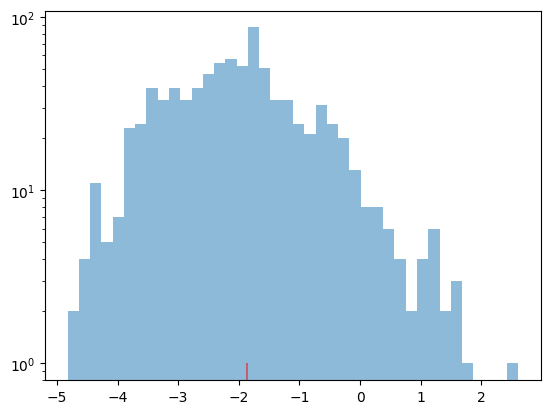

In [254]:
plt.hist(df_with_scores['score'], bins=40, alpha=0.5, label='scores', log=True)
plt.hist(chinese_aso['score'], bins=40, alpha=0.5, color='red', label='scores', log=True)

plt.show()

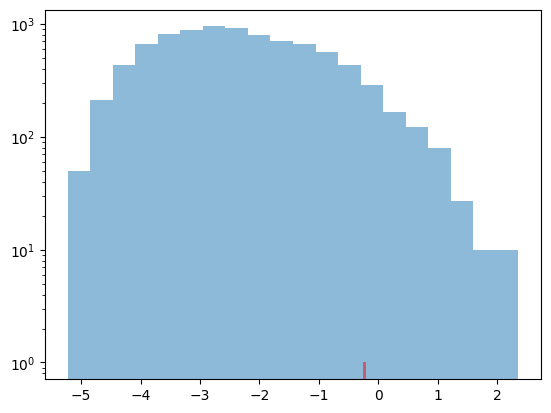

-0.24987552
5115    0.075482
Name: relative_score, dtype: float64


In [255]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

EXAMPLE = 'GGCATATGCAGATAATGTTC'

plt.hist(df_with_scores['score'], bins=20, alpha=0.5, label='scores', log=True)
plt.hist(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'], bins=20, alpha=0.5, color='red', label='scores', log=True)

plt.show()
score = df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'].iloc[0]
len(df_with_scores[df_with_scores['score'] > score]) / len(df_with_scores)
print(score)
print(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['relative_score'])

In [33]:
k = 10  # how many bot rows
idx = np.argsort(scores)[:k]
print(df_with_scores.iloc[idx])
# print(df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA'])

                  Sequence  sense_start  sense_length  sense_start_from_end  \
4218  AAACTAAACAATTACCTAAA         4218            20                  4611   
251   CTATAAGGACAGCTAAGATA          251            20                  8578   
4830  TACAAACAGATAAGTTTAAA         4830            20                  3999   
7066  CATAAACAATGCACTAAAGA         7066            20                  1763   
7067  ACATAAACAATGCACTAAAG         7067            20                  1762   
4593  TATTAAATCACCTGAAAAAA         4593            20                  4236   
4829  ACAAACAGATAAGTTTAAAA         4829            20                  4000   
2314  TAAAATAAATTGGTTACCAA         2314            20                  6515   
523   AAGTAGACCAACTAAGCGAA          523            20                  8306   
4224  AATCATAAACTAAACAATTA         4224            20                  4605   

     Canonical Gene Name  Treatment_Period(hours)  ASO_volume(nM)  \
4218               MALAT                       24            

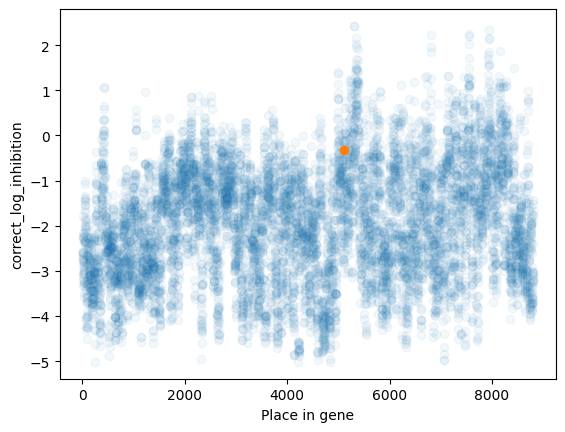

Feature: sense_start                        , Pearson: 0.19 , p-value: 4.7e-70    Target: score                              
Feature: sense_start                        , Spearman: 0.18 , p-value: 3e-62      Target: score                              
Feature: sense_start                        , MIC:      0.35                              Target: score                              


In [43]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

metric = 'correct_log_inhibition'
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")


# for gene in genes_u:
# print("gene, ", gene)
feature = 'sense_start'
current_df = df_with_scores[df_with_scores[CANONICAL_GENE] == 'MALAT']
plt.scatter(current_df[feature], current_df['score'], alpha=0.05)
plt.scatter(current_df[current_df[SEQUENCE] == EXAMPLE][feature], current_df[current_df[SEQUENCE] == EXAMPLE]['score'])
plt.xlabel('Place in gene')
plt.ylabel(f'{metric}')
plt.show()

print_correlations(current_df, feature, 'score')
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', metric)
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', 'score')


In [ ]:
for feature in features:
    plt.scatter(current_df[feature], current_df['score'])
    # plt.scatter(current_df[feature], current_df['log_inhibition'])
    special_aso = current_df[current_df[SEQUENCE] == 'GGCATATGCAGATAATGTTC']
    plt.scatter(special_aso[feature], special_aso['score'])
    plt.xlabel(f'Feature: {feature}')
    plt.ylabel(f'Score: {score}')
    plt.show()